## Task 1

#### Uber rides

The original data is available at this location: https://www.kaggle.com/anupammajhi/uber-request-data

*Note that the original data was too clean, so I decided to remove some values from the Pickup point column so that they can be imputed; the modified version of the .csv file is available on my github.*

*Further note that I generated some extra price data in a separate file which the original data can be enriched with. It is also available on my github.*

In [1]:
#import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer


Let us look at a random sets of a few records to have a feel for the datasets

In [2]:
# requests
uber_request = pd.read_csv('~/Uber Request Data.csv', parse_dates=['Request timestamp', 'Drop timestamp'])
uber_request.sample(5)

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
2747,5297,City,290.0,Trip Completed,2016-07-14 21:51:00,2016-07-14 22:25:00
5663,4159,Airport,NaN,No Cars Available,2016-07-14 05:05:00,NaT
537,4233,Airport,55.0,Trip Completed,2016-07-14 05:51:00,2016-07-14 06:58:00
5520,3861,Airport,NaN,No Cars Available,2016-07-13 21:47:00,NaT
2543,4714,City,268.0,Trip Completed,2016-07-14 13:30:00,2016-07-14 14:04:00


In [3]:
# price
uber_px = pd.read_csv('~/Uber Request Prices.csv')
uber_px.sample(5)

,Request id,Price
2115,6086,106.880445
4097,1366,NaN
928,1524,123.239222
2609,757,76.203797
5485,3803,NaN


Combine the dataset (i.e. enrich the original request data with prices) using Request id column

In [4]:
uber = pd.merge(left=uber_request, right=uber_px, how='left', left_on='Request id', right_on='Request id')
uber.sample(5)

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Price
2897,4586,City,20.0,Cancelled,2016-07-14 10:09:00,NaT,NaN
1719,3634,City,181.0,Trip Completed,2016-07-13 19:00:00,2016-07-13 19:54:00,132.238519
2566,6111,City,270.0,Trip Completed,2016-07-15 15:03:00,2016-07-15 16:15:00,159.542094
5874,4907,Airport,NaN,No Cars Available,2016-07-14 18:10:00,NaT,NaN
5393,3642,Airport,NaN,No Cars Available,2016-07-13 19:07:00,NaT,NaN


#### Exploratory Data Analysis (EDA)

EDA involves analysing the dataset to summarise its main characteristics

First, I created a summary table to better understand the variables (features) of the data set

In [5]:
# number of total records
print(f'Number of records: {len(uber)}')

# new dataframe to store the properties of the uber df's columns
features = pd.DataFrame(columns=['Variable',
                                 'Number of missing values',
                                 'Proportion of missing values',
                                 'Number of unique values','Values',
                                 'Data type'
                            ])

# populate the features dataframe
for i, col in enumerate(uber.columns):
    features.loc[i] = [col,                                                       # column (feature) name
                       pd.isna(uber[col]).sum(),                                  # number of missing values
                       (pd.isna(uber[col]).sum() / len(uber[col])).round(3),      # proportion of missing values
                       uber[col].nunique(),                                       # number of unique values
                       uber[col].unique().tolist(),                               # list of unique values
                       uber[col].dtype                                            # column (feature) data type
                    ]
    
features

Number of records: 6745


,Variable,Number of missing values,Proportion of missing values,Number of unique values,Values,Data type
0,Request id,0,0.000,6745,"[619, 867, 1807, 2532, 3112, 3879, 4270, 5510,...",int64
1,Pickup point,20,0.003,2,"[Airport, City, nan]",object
2,Driver id,2650,0.393,300,"[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...",float64
3,Status,0,0.000,3,"[Trip Completed, Cancelled, No Cars Available]",object
4,Request timestamp,0,0.000,4016,"[1478519460000000000, 1478541420000000000, 148...",datetime64[ns]
5,Drop timestamp,3914,0.580,2282,"[1478523600000000000, 1478544420000000000, 148...",datetime64[ns]
6,Price,3911,0.580,2833,"[186.0417624, 102.5716891, 78.41048784, 148.58...",float64


Key observations:
    
    - Request id: there are all unique ids (number of unique ids = number of records)
    
    - Pickup point: 20 missing + two unique values: City and Airport; could be converted to categorical
    
    - Driver id: many missing values (~40%); 300 unique drivers; verify data is missing when no car available
    
    - Status: 3 unique values; could be converted to categorical
    
    - Request timestamp: no missing values, all unique as expected
    
    - Drop timestamp: many missing values (58%); yet to verify it's only filled in when trip completed
    
    - Price: many missing values but 4 fewer than for Drop timestamp

In [6]:
# convert aforementioned feature dtypes to category
uber['Pickup point'] = uber['Pickup point'].astype('category')
uber['Status'] = uber['Status'].astype('category')

Confirming that the above hypotheses regarding missing values in Driver id and Drop timestamp columns check out

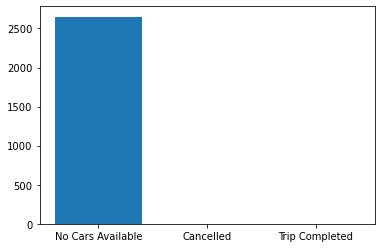

In [7]:
missing_drivers = uber.loc[np.isnan(uber['Driver id']), 'Status'].value_counts()
plt.bar(missing_drivers.index, missing_drivers);

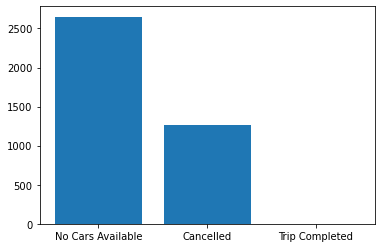

In [8]:
missing_drop_timestamps = uber.loc[np.isnan(uber['Drop timestamp']), 'Status'].value_counts()
plt.bar(missing_drop_timestamps.index, missing_drop_timestamps);

They are both true indeed - the driver information is only missing where there was no car available and missing drop timestamp is only missing where either no car was available or the person requested the trip cancelled it

As we have seen earlier, there are 20 records where Pickup point is not populated. They are genuinely missing values (as opposed to the ones we looked at above) as there is not reason why they should not be populated.

Missing values can cause problems down the line as, for example, many machine learning models cannot work with them. Generally, there are two options to tackle them. One, is to delete all records with missing values and two, to fill in the missing values (aka data imputation). Many times selecting the best option is more art than science but there are some rules of thumbs we can follow. For example, if the number of records with missing values accounts for only a tiny fraction of the dataset, it is probably fine to get rid of them.

In this case we could probably just delete these records but I am going keep to demonstrate data imputation.

Filling in missing values is a common task as many real life dataset has patchy data. In case of numerical values, we usually impute the given column's (aka attrbiute or feature) mean or median value. For categorical values, we can impute the most common value. Note that there are other, more complex methods such as KNNImputer that allows us to find a specified number of properly populated records that are similar to the one with missing value, and impute the value that's most common amongst these similar records.

Here, however, I'm just going to use the SimpleImputer.

In [9]:
# replace missing values with the most frequent value in the column
si = SimpleImputer(strategy='most_frequent')

uber['Pickup point'] = si.fit_transform(uber['Pickup point'].to_numpy().reshape(-1, 1))

In [10]:
# confirm that there are no missing values
uber['Pickup point'].value_counts(dropna=False)

City       3512
Airport    3233
Name: Pickup point, dtype: int64

As we have seen earlier, 58% of the records did not finish in a completed trip. This requires further investigation. First, let us look at whether the pickup location makes any difference.

We can see that there are significant number of non-completed trips regardless of the pickup location. It is worth noting though, that there is a big difference in the reason why: the vast majority of pickups requested at the airports got cancelled because of no available cars. In contrast, in the city it is a much more balanced picture between the two reasons.

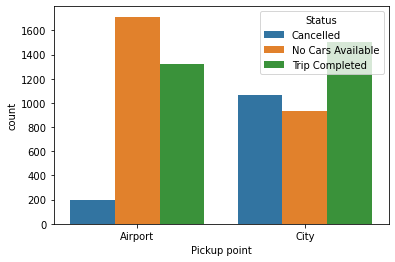

In [11]:
sns.countplot(data=uber, x='Pickup point', hue='Status');

It would be interesting to see if part of the day plays a role in this massive imbalance in case of airport pickups. Let us derive the hours from the request timestamps and plot the different status against the hours of the day.

It is clear that there is a massive spike in demand roughly from 5pm to 9pm that is not met by supply, hence the large increase in not completed requests due to no available cars.

It is also interesting to look at the same chart for City pickups. We can see similar pickup in demand; however, as probably expected, it is in the morning hours from 5am to 9am.

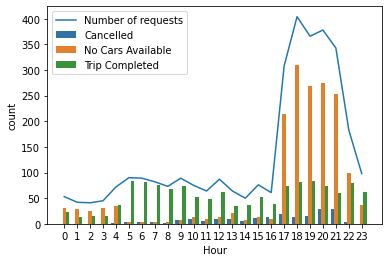

In [12]:
mask = uber['Pickup point'] == 'Airport'
hours = uber.loc[mask, 'Request timestamp'].dt.hour
sns.countplot(data=uber[mask], x=hours, hue='Status')
plt.plot(uber[mask].groupby(hours)['Request id'].agg(np.size), label='Number of requests')
plt.xlabel('Hour')
plt.legend(loc='upper left');

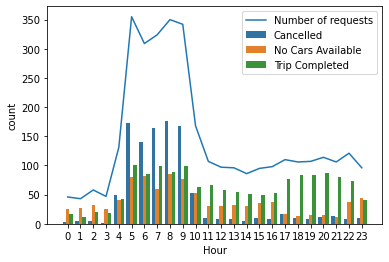

In [13]:
mask = uber['Pickup point'] == 'City'
hours = uber.loc[mask, 'Request timestamp'].dt.hour
sns.countplot(data=uber[mask], x=hours, hue='Status')
plt.plot(uber[mask].groupby(hours)['Request id'].agg(np.size), label='Number of requests')
plt.xlabel('Hour')
plt.legend(loc='upper right');

Next, let us look into the number of trips the different drivers completed. I created two charts to illustrate this. The first one is a histogram and the second one is a boxplot. Both chart types are commonly used to visualise frequency distributions.

The histogram shows how often each different value of the number of completed trips per driver occurs in the dataset. I have also added an estimate of the closest Gaussian distribution. We can see that altough the data resembles a Gaussian (normal) distribution, there is a massive spike (value concentration) around the middle of the distribution making it leptokurtic.

As for the boxplot, the box in the middle represents the so-called interquartile range which means the data points that fall between the 25th and 75th percentiles. The length of the lines (whiskers) extending from this box indicates the extent to which the data varies outside of these said percentiles. If there were outliers in the data, we would see little dots representing them beyond the end of the whiskers.

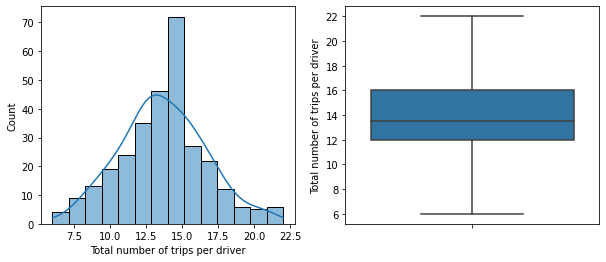

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
g = sns.histplot(uber['Driver id'].value_counts(),ax=axs[0], kde=True)
h = sns.boxplot(data=uber, orient='v', y=uber['Driver id'].value_counts(), ax=axs[1])

g.set(xlabel='Total number of trips per driver')
h.set(ylabel='Total number of trips per driver');

Finally, let us investigate prices!

The first thing to check is whether there is any missing value for completed trips, which would then require either filling them in with the mean/median or getting rid of these records altogether. We find that there is one completed trip with a missing price, so we plug in the mean.

The other way around (i.e. not a completed trip yet it has a price) is probably less important but there are 4 such cases that we can fix by updating prices with np.nans.

In [15]:
mask1 = uber.Price.isna()
mask2 = uber['Status'] == 'Trip Completed'
uber[mask1 & mask2]

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Price
10,1467,Airport,2.0,Trip Completed,2016-12-07 05:08:00,2016-12-07 06:02:00,NaN


In [16]:
# fill in missing value with mean price
uber.loc[mask1 & mask2, 'Price'] = np.mean(uber.Price)

In [17]:
mask1 = uber.Price.isna()
mask2 = uber['Status'] != 'Trip Completed'
uber[~mask1 & mask2]

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Price
2856,3184,City,7.0,Cancelled,2016-07-13 09:21:00,NaT,117.286271
2857,1687,City,8.0,Cancelled,2016-12-07 07:51:00,NaT,147.183606
2858,4174,City,8.0,Cancelled,2016-07-14 05:19:00,NaT,163.768428
2950,2305,City,33.0,Cancelled,2016-12-07 18:56:00,NaT,163.768428


In [18]:
# update prices for not completed trips with np.nans
mask1 = uber.Price.isna()
mask2 = uber['Status'] != 'Trip Completed'
uber.loc[~mask1 & mask2, 'Price'] = np.nan

Using pandas .describe() method we can have a sense of the distribution of the prices. Notice that the max value is huge relative to even the 75th percentile indicating the presence of outliers.

Outliers are observations that generally speaking do not fit in. They can be thought of as anomalies. They can lead to measurement errors and adversely affect the performance of many machine learning models, among others, so it is a good idea to do something about them. There are many methods at our disposal including some of the methods discussed earlier for data imputation. What I am going to use here is called clipping where if a value of an attribute is either above or below a certain threshold, it gets substituted with the threshold value. I set these threshold values to be the 0.5% and 99.5% percentiles.

We can see that clipping the outliers resulted in a much smaller maximum value, that looks a lot more reasonable as it is less than 3 standard deviations away from the mean.

In [19]:
uber.Price.describe()

count     2831.000000
mean       119.279537
std        323.821528
min         34.594305
25%         81.305835
50%        104.899879
75%        133.363958
max      11359.242720
Name: Price, dtype: float64

In [20]:
lower_threshold = np.percentile(uber.Price.dropna(), 0.5)
upper_threshold = np.percentile(uber.Price.dropna(), 99.5)
clipped_prices = np.clip(uber.Price, lower_threshold, upper_threshold)
zscore_1 = (max(clipped_prices) - np.mean(clipped_prices)) / np.std(clipped_prices)
zscore_2 = (np.mean(clipped_prices) - min(clipped_prices)) / np.std(clipped_prices)

print(f"Max z-score: {max(zscore_1, zscore_2):.2f}")
clipped_prices.describe()

Max z-score: 2.62


count    2831.000000
mean      108.931430
std        36.090239
min        43.446727
25%        81.305835
50%       104.899879
75%       133.363958
max       203.444382
Name: Price, dtype: float64

Finally, plot the distribution of the clipped prices to have a sense of how expensive it is to ride an Uber! *Note again that I randomly generated most of these "prices"*

The histogram exhibits a pronounced positive (right) skew, so the rides on the cheaper end are more frequent. We may wonder how prices relate to the length of the rides calculated as the difference between the request and drop off times in seconds. Calculating the correlation coefficient indicates that there is no linear relationship between the two.

<AxesSubplot:ylabel='Price'>

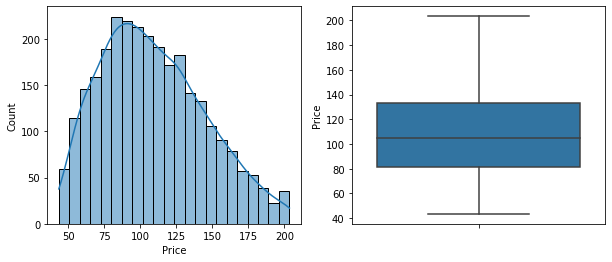

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))
sns.histplot(clipped_prices,ax=axs[0], kde=True)
sns.boxplot(orient='v', y=clipped_prices, ax=axs[1])

In [22]:
# timedelta in seconds
total_seconds = (uber['Drop timestamp'] - uber['Request timestamp']).dropna().dt.total_seconds()

# calculating correlation
np.corrcoef(total_seconds, clipped_prices.dropna())

array([[1.        , 0.00515974],
       [0.00515974, 1.        ]])